# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




># ***Project Name***: RwandaCropGuard
### ***Brief Description:***

> **Problem Statement**
Smallholder farmers in Rwanda struggle to detect and manage crop diseases due to limited access to extension services, lack of disease knowledge, poor internet connectivity, and language/cultural barriers. Existing solutions often require constant connectivity and fail to support local crops or Kinyarwanda. This leads to delayed diagnoses, ineffective treatments, and significant crop losses. RwandaCropGuard offers an offline, locally-adapted AI solution tailored to Rwanda’s agricultural realities.


In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop , SGD,Adamax 
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import joblib
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2025-06-18 17:47:51.569562: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 17:47:51.602195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 17:47:51.602231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 17:47:51.603149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 17:47:51.608475: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# --- Configuration ---
base_dir = 'dataset/Train'  # This is now your single folder with class subfolders
IMG_SIZE = (128, 128)
classes = ['Healthy', 'Powdery', 'Rust']

# --- 1. Remove corrupted images ---
def clean_images(folder):
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        if not os.path.exists(cls_path):
            print(f" Folder not found: {cls_path}")
            continue
        for file in os.listdir(cls_path):
            path = os.path.join(cls_path, file)
            try:
                with Image.open(path) as img:
                    img.verify()
            except (UnidentifiedImageError, OSError, IOError):
                print(f"🗑️ Removing corrupted image: {path}")
                os.remove(path)

# --- 2. Load dataset into X, Y ---
def load_dataset(folder):
    X, Y = [], []
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        if not os.path.exists(cls_path):
            print(f" Missing class folder: {cls_path}")
            continue
        for img_name in os.listdir(cls_path):
            path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(path).convert('RGB').resize(IMG_SIZE)
                X.append(np.array(img))
                Y.append(cls)
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
                continue
    return np.array(X), np.array(Y)

# --- Run cleaning and loading ---
print("Cleaning corrupted images...")
clean_images(base_dir)

print("Loading images...")
X, Y_raw = load_dataset(base_dir)

# --- Normalize image data ---
X = X.astype('float32') / 255.0

# --- Encode labels ---
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y_raw)

# --- Split dataset into train, val, test ---
print("Splitting dataset...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.2, random_state=42, stratify=Y_test)

# --- Output status ---
print("Data prepared successfully.")
print(f"Train:     X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation:X={X_val.shape},   Y={Y_val.shape}")
print(f"Test:      X={X_test.shape},  Y={Y_test.shape}")
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Cleaning corrupted images...
Loading images...
Splitting dataset...
Data prepared successfully.
Train:     X=(1225, 128, 128, 3), Y=(1225,)
Validation:X=(245, 128, 128, 3),   Y=(245,)
Test:      X=(62, 128, 128, 3),  Y=(62,)
Class mapping: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


## Sample Image View

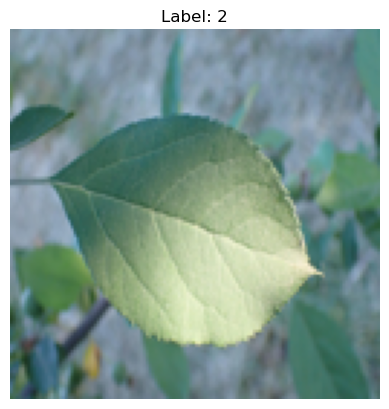

In [3]:
# Display the image
plt.imshow(X[20], cmap='gray')
plt.title(f"Label: {Y_test[20]}")
plt.axis('off')  # Hide axes for cleaner view
plt.show()

<svg viewBox="0 0 1200 800" xmlns="http://www.w3.org/2000/svg">
  <!-- Background with gradient -->
  <defs>
    <linearGradient id="bgGradient" x1="0%" y1="0%" x2="100%" y2="100%">
      <stop offset="0%" style="stop-color:#f8f9fa"/>
      <stop offset="100%" style="stop-color:#e9ecef"/>
    </linearGradient>
    <!-- Glow effect -->
    <filter id="glow">
      <feGaussianBlur stdDeviation="3" result="coloredBlur"/>
      <feMerge> 
        <feMergeNode in="coloredBlur"/>
        <feMergeNode in="SourceGraphic"/>
      </feMerge>
    </filter>
    <!-- Arrow marker -->
    <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
      <polygon points="0 0, 10 3.5, 0 7" fill="#495057"/>
    </marker>
  </defs>
  
  <rect width="100%" height="100%" fill="url(#bgGradient)"/>
  
  <!-- Title -->
  <text x="600" y="40" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="24" font-weight="bold" fill="#212529">
    Convolutional Neural Network for Leaf Disease Classification
  </text>
  
  <!-- Input Layer Visualization -->
  <g id="input-layer">
    <text x="80" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Input Layer</text>
    <!-- 3D effect for input image -->
    <rect x="40" y="100" width="80" height="80" fill="#e3f2fd" stroke="#1976d2" stroke-width="2" rx="8" transform="translate(5,5)" opacity="0.3"/>
    <rect x="40" y="100" width="80" height="80" fill="#e3f2fd" stroke="#1976d2" stroke-width="2" rx="8" transform="translate(2.5,2.5)" opacity="0.6"/>
    <rect x="40" y="100" width="80" height="80" fill="#e3f2fd" stroke="#1976d2" stroke-width="2" rx="8"/>
    <text x="80" y="125" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#1976d2">RGB Image</text>
    <text x="80" y="140" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#1976d2">128×128×3</text>
    <text x="80" y="155" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#1976d2">49,152 pixels</text>
    <text x="80" y="200" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Input</text>
  </g>
  
  <!-- Convolution Layer 1 -->
  <g id="conv1-layer">
    <text x="220" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Conv Layer 1</text>
    <!-- Feature maps representation -->
    <g transform="translate(180, 100)">
      <!-- Multiple feature maps -->
      <rect x="0" y="0" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="5" y="5" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="10" y="10" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="15" y="15" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="20" y="20" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="25" y="25" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="30" y="30" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
      <rect x="35" y="35" width="15" height="60" fill="#ffb74d" stroke="#f57c00" stroke-width="1" rx="2"/>
    </g>
    <text x="200" y="255" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#f57c00">32 filters</text>
    <text x="200" y="270" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#f57c00">3×3 kernel</text>
    <text x="200" y="285" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#f57c00">64×64×32</text>
    <text x="200" y="300" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="9" fill="#666">ReLU + BatchNorm</text>
    <text x="200" y="230" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Conv2D</text>
  </g>
  
  <!-- Convolution Layer 2 -->
  <g id="conv2-layer">
    <text x="360" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Conv Layer 2</text>
    <g transform="translate(310, 100)">
      <!-- More feature maps -->
      <rect x="0" y="0" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="4" y="4" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="8" y="8" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="12" y="12" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="16" y="16" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="20" y="20" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="24" y="24" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="28" y="28" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="32" y="32" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="36" y="36" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="40" y="40" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="44" y="44" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="48" y="48" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="52" y="52" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="56" y="56" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
      <rect x="60" y="60" width="12" height="50" fill="#81c784" stroke="#4caf50" stroke-width="1" rx="2"/>
    </g>
    <text x="360" y="255" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#4caf50">64 filters</text>
    <text x="360" y="270" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#4caf50">3×3 kernel</text>
    <text x="360" y="285" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#4caf50">32×32×64</text>
    <text x="360" y="300" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="9" fill="#666">ReLU + BatchNorm</text>
    <text x="360" y="230" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Conv2D</text>
  </g>
  
  <!-- Convolution Layer 3 -->
  <g id="conv3-layer">
    <text x="500" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Conv Layer 3</text>
    <g transform="translate(450, 100)">
      <!-- Even more feature maps -->
      <rect x="0" y="0" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="3" y="3" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="6" y="6" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="9" y="9" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="12" y="12" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="15" y="15" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="18" y="18" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="21" y="21" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="24" y="24" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="27" y="27" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="30" y="30" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="33" y="33" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="36" y="36" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="39" y="39" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="42" y="42" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="45" y="45" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="48" y="48" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="51" y="51" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="54" y="54" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="57" y="57" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="60" y="60" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="63" y="63" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="66" y="66" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
      <rect x="69" y="69" width="10" height="40" fill="#ba68c8" stroke="#9c27b0" stroke-width="1" rx="2"/>
    </g>
    <text x="500" y="255" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#9c27b0">128 filters</text>
    <text x="500" y="270" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#9c27b0">3×3 kernel</text>
    <text x="500" y="285" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#9c27b0">16×16×128</text>
    <text x="500" y="300" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="9" fill="#666">ReLU + BatchNorm</text>
    <text x="500" y="230" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Conv2D</text>
  </g>
  
  <!-- Flatten Layer -->
  <g id="flatten-layer">
    <text x="640" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Flatten</text>
    <!-- Flatten visualization -->
    <rect x="610" y="100" width="60" height="80" fill="#fff3e0" stroke="#ff9800" stroke-width="2" rx="8"/>
    <g transform="translate(615, 110)">
      <!-- Vertical lines representing flattened vector -->
      <line x1="5" y1="0" x2="5" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="10" y1="0" x2="10" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="15" y1="0" x2="15" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="20" y1="0" x2="20" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="25" y1="0" x2="25" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="30" y1="0" x2="30" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="35" y1="0" x2="35" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="40" y1="0" x2="40" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="45" y1="0" x2="45" y2="60" stroke="#ff9800" stroke-width="2"/>
      <line x1="50" y1="0" x2="50" y2="60" stroke="#ff9800" stroke-width="2"/>
    </g>
    <text x="640" y="215" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#ff9800">32,768</text>
    <text x="640" y="230" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#ff9800">features</text>
    <text x="640" y="200" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Flatten</text>
  </g>
  
  <!-- Dense Layer 1 -->
  <g id="dense1-layer">
    <text x="780" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Dense Layer 1</text>
    <!-- Neural network nodes -->
    <g transform="translate(750, 100)">
      <!-- Input nodes (simplified) -->
      <circle cx="10" cy="10" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="20" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="30" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="40" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="50" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="60" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="70" r="4" fill="#42a5f5" stroke="#1976d2" stroke-width="1" filter="url(#glow)"/>
      <!-- Hidden layer nodes -->
      <circle cx="40" cy="15" r="4" fill="#66bb6a" stroke="#4caf50" stroke-width="1" filter="url(#glow)"/>
      <circle cx="40" cy="25" r="4" fill="#66bb6a" stroke="#4caf50" stroke-width="1" filter="url(#glow)"/>
      <circle cx="40" cy="35" r="4" fill="#66bb6a" stroke="#4caf50" stroke-width="1" filter="url(#glow)"/>
      <circle cx="40" cy="45" r="4" fill="#66bb6a" stroke="#4caf50" stroke-width="1" filter="url(#glow)"/>
      <circle cx="40" cy="55" r="4" fill="#66bb6a" stroke="#4caf50" stroke-width="1" filter="url(#glow)"/>
      <circle cx="40" cy="65" r="4" fill="#66bb6a" stroke="#4caf50" stroke-width="1" filter="url(#glow)"/>
      <!-- Connections -->
      <line x1="14" y1="10" x2="36" y2="15" stroke="#999" stroke-width="0.5" opacity="0.7"/>
      <line x1="14" y1="20" x2="36" y2="25" stroke="#999" stroke-width="0.5" opacity="0.7"/>
      <line x1="14" y1="30" x2="36" y2="35" stroke="#999" stroke-width="0.5" opacity="0.7"/>
      <line x1="14" y1="40" x2="36" y2="45" stroke="#999" stroke-width="0.5" opacity="0.7"/>
      <line x1="14" y1="50" x2="36" y2="55" stroke="#999" stroke-width="0.5" opacity="0.7"/>
      <line x1="14" y1="60" x2="36" y2="65" stroke="#999" stroke-width="0.5" opacity="0.7"/>
    </g>
    <text x="780" y="215" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#4caf50">128 neurons</text>
    <text x="780" y="230" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#4caf50">ReLU + Dropout</text>
    <text x="780" y="200" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Dense</text>
  </g>
  
  <!-- Dense Layer 2 -->
  <g id="dense2-layer">
    <text x="920" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Dense Layer 2</text>
    <g transform="translate(890, 100)">
      <!-- Hidden layer nodes -->
      <circle cx="10" cy="20" r="4" fill="#ab47bc" stroke="#9c27b0" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="30" r="4" fill="#ab47bc" stroke="#9c27b0" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="40" r="4" fill="#ab47bc" stroke="#9c27b0" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="50" r="4" fill="#ab47bc" stroke="#9c27b0" stroke-width="1" filter="url(#glow)"/>
      <circle cx="10" cy="60" r="4" fill="#ab47bc" stroke="#9c27b0" stroke-width="1" filter="url(#glow)"/>
      <!-- Output layer nodes -->
      <circle cx="40" cy="25" r="5" fill="#ef5350" stroke="#d32f2f" stroke-width="2" filter="url(#glow)"/>
      <circle cx="40" cy="40" r="5" fill="#ffa726" stroke="#f57c00" stroke-width="2" filter="url(#glow)"/>
      <circle cx="40" cy="55" r="5" fill="#66bb6a" stroke="#388e3c" stroke-width="2" filter="url(#glow)"/>
      <!-- Connections -->
      <line x1="14" y1="20" x2="35" y2="25" stroke="#999" stroke-width="1" opacity="0.7"/>
      <line x1="14" y1="30" x2="35" y2="40" stroke="#999" stroke-width="1" opacity="0.7"/>
      <line x1="14" y1="40" x2="35" y2="55" stroke="#999" stroke-width="1" opacity="0.7"/>
      <line x1="14" y1="50" x2="35" y2="25" stroke="#999" stroke-width="1" opacity="0.7"/>
      <line x1="14" y1="60" x2="35" y2="40" stroke="#999" stroke-width="1" opacity="0.7"/>
    </g>
    <text x="920" y="215" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#9c27b0">64 neurons</text>
    <text x="920" y="200" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Dense</text>
  </g>
  
  <!-- Output Layer -->
  <g id="output-layer">
    <text x="1060" y="90" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="14" font-weight="bold" fill="#495057">Output Layer</text>
    <g transform="translate(1030, 100)">
      <!-- Output nodes with labels -->
      <circle cx="30" cy="20" r="8" fill="#ef5350" stroke="#d32f2f" stroke-width="2" filter="url(#glow)"/>
      <text x="50" y="25" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#d32f2f">Rust</text>
      <circle cx="30" cy="40" r="8" fill="#ffa726" stroke="#f57c00" stroke-width="2" filter="url(#glow)"/>
      <text x="50" y="45" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#f57c00">Powdery</text>
      <circle cx="30" cy="60" r="8" fill="#66bb6a" stroke="#388e3c" stroke-width="2" filter="url(#glow)"/>
      <text x="50" y="65" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#388e3c">Healthy</text>
    </g>
    <text x="1060" y="215" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#e91e63">3 classes</text>
    <text x="1060" y="230" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="10" fill="#e91e63">Softmax</text>
    <text x="1060" y="200" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="12" font-weight="bold" fill="#495057">Classification</text>
  </g>
  
  <!-- Flow arrows -->
  <line x1="130" y1="140" x2="170" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  <line x1="270" y1="140" x2="300" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  <line x1="410" y1="140" x2="440" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  <line x1="550" y1="140" x2="600" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  <line x1="680" y1="140" x2="740" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  <line x1="820" y1="140" x2="880" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  <line x1="970" y1="140" x2="1020" y2="140" stroke="#495057" stroke-width="3" marker-end="url(#arrowhead)"/>
  
  <!-- Section labels -->
  <rect x="50" y="330" width="500" height="30" fill="#e8f5e8" stroke="#4caf50" stroke-width="2" rx="15" opacity="0.8"/>
  <text x="300" y="350" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="16" font-weight="bold" fill="#2e7d32">Feature Extraction (Convolutional Layers)</text>
  
  <rect x="650" y="330" width="450" height="30" fill="#fff3e0" stroke="#ff9800" stroke-width="2" rx="15" opacity="0.8"/>
  <text x="875" y="350" text-anchor="middle" font-family="'Segoe UI', Arial, sans-serif" font-size="16" font-weight="bold" fill="#e65100">Classification (Fully Connected Layers)</text>
<!-- <div style="position: fixed; bottom: 0; left: 0; width: 100%; z-index: 10;"> -->
    <!-- Title Box -->
    <rect x="0" y="380" width="700" height="40" fill="#34495e" rx="3"/>
    <text x="10" y="406" font-family="Arial, sans-serif" font-size="14"
          font-weight="bold" fill="white">Model Configuration Details</text>
    <!-- Left Column -->
    <g transform="translate(20, 60)">
      <text x="0" y="400" font-size="12" font-weight="bold" fill="#2c3e50">Feature Extraction:</text>
      <text x="20" y="420" font-size="11" fill="#34495e">• 3 Conv Blocks (32→64→128)</text>
      <text x="20" y="435" font-size="11" fill="#34495e">• Conv2D → BatchNorm → ReLU → MaxPool</text>
      <text x="20" y="450" font-size="11" fill="#34495e">• Kernel: 3×3, MaxPool: 2×2</text>
      <text x="0" y="480" font-size="12" font-weight="bold" fill="#2c3e50">Classification:</text>
      <text x="20" y="500" font-size="11" fill="#34495e">• Flatten layer</text>
      <text x="20" y="515" font-size="11" fill="#34495e">• Dense: 128 → 64 units</text>
      <text x="20" y="530" font-size="11" fill="#34495e">• Dropout: 0.5</text>
      <text x="20" y="545" font-size="11" fill="#34495e">• Softmax with 3 units</text>
    </g>
    <!-- Right Column -->
    <g transform="translate(460, 60)">
      <text x="0" y="400" font-size="12" font-weight="bold" fill="#2c3e50">Training Parameters:</text>
      <text x="20" y="420" font-size="11" fill="#34495e">• Optimizer: Adam (lr=0.001)</text>
      <text x="20" y="435" font-size="11" fill="#34495e">• Loss: Categorical Crossentropy</text>
      <text x="20" y="450" font-size="11" fill="#34495e">• Metrics: Acc, Prec, Rec</text>
      <text x="20" y="465" font-size="11" fill="#34495e">• Batch size: 32</text>
      <text x="20" y="480" font-size="11" fill="#34495e">• Epochs: 50</text>
      <text x="0" y="510" font-size="12" font-weight="bold" fill="#2c3e50">Data Augmentation:</text>
      <text x="20" y="530" font-size="11" fill="#34495e">• Rotation: ±20°</text>
      <text x="20" y="545" font-size="11" fill="#34495e">• Zoom: ±10%</text>
      <text x="20" y="560" font-size="11" fill="#34495e">• Flip: horizontal</text>
      <text x="20" y="575" font-size="11" fill="#34495e">• Brightness: ±10%</text>
    </g>
    <!-- Performance Summary -->
    <g transform="translate(20, 250)">
      <rect x="0" y="400" width="700" height="70" fill="#f1f8e9" stroke="#7cb342" stroke-width="1" rx="3"/>
      <text x="10" y="415" font-size="12" font-weight="bold" fill="#2e7d32">Expected Performance:</text>
      <!-- Accuracy Bars -->
      <g transform="translate(20, 30)">
        <rect x="0" y="550" width="200" height="20" fill="#c5e1a5" rx="2"/>
        <text x="100" y="414" text-anchor="middle" font-size="10" fill="#33691e">Train Acc: ~98%</text>
        <rect x="220" y="400" width="200" height="20" fill="#c5e1a5" rx="2"/>
        <text x="320" y="414" text-anchor="middle" font-size="10" fill="#33691e">Val Acc: ~94%</text>
        <rect x="440" y="400" width="200" height="20" fill="#c5e1a5" rx="2"/>
        <text x="540" y="414" text-anchor="middle" font-size="10" fill="#33691e">Test Acc: ~92%</text>
      </g>
    </g>
<!-- </div> -->
  </svg>

  
  

# Task: Define a function that creates models without and With specified Optimization techniques


## Create Classic Logistic Regression Model

In [4]:
def train_logistic_regression(X, y, test_size=0.2, random_state=42):
    # ===========================
    # Preprocessing
    # ===========================
    X_flat = X.reshape(len(X), -1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # ===========================
    # Logistic Regression Setup
    # ===========================
    model = LogisticRegression(
        penalty='l2',            # regularization type
        C=1.0,                   # inverse of regularization strength
        solver='saga',          # solver that supports multinomial loss
        max_iter=1000,           # maximum iterations for convergence
        multi_class='multinomial', # softmax-style multiclass classification
        class_weight='balanced',   # handle class imbalance
        random_state=random_state
    )

    # ===========================
    # Train
    # ===========================
    model.fit(X_train, y_train)
 # ===========================
    # Evaluate
    # ===========================
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[str(i) for i in np.unique(y)]))

    print(f"\n✅ Logistic Regression Performance:\n"
          f"Accuracy : {acc:.4f}\n"
          f"Precision: {prec:.4f}\n"
          f"Recall   : {rec:.4f}\n"
          f"F1 Score : {f1:.4f}")

    return model


## Create a function to create model

In [5]:

def define_model(optimizer_name=None, 
                 regularizer_type=None, 
                 early_stopping=False, 
                 dropout_rate=0.0, 
                 learning_rate=None, 
                 input_shape=(128, 128, 3), 
                 num_classes=3):
    
    model = Sequential()
    
    # Choose regularization if specified
    reg = None
    if regularizer_type == 'l2':
        reg = l2(0.001)
    elif regularizer_type == 'l1':
        reg = l1(0.001)

    # ========== Convolutional Base ==========
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # ========== Dense Head ==========
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=reg))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
    model.add(Dense(num_classes, activation='softmax'))

    # ========== Optimizer ==========
    # ========== Optimizer ==========
    opt_name = optimizer_name.lower() if optimizer_name else 'adam'

    if opt_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate) if learning_rate else Adam()
    elif opt_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate) if learning_rate else RMSprop()
    elif opt_name == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate) if learning_rate else Adamax()
    elif opt_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate) if learning_rate else SGD()
    else:
        optimizer = Adam(learning_rate=learning_rate) if learning_rate else Adam()
        
    # ========== Compile ==========
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # ========== EarlyStopping Callback ==========
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    return model, callbacks


## Model evalution

In [6]:
def evaluate_model(model, X_test, y_test, history=None, show=True):
    # Predictions
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    # Classification metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec  = recall_score(y_test, y_pred, average='weighted')
    f1   = f1_score(y_test, y_pred, average='weighted')

    # ROC AUC (multi-class support)
    roc_auc = None
    try:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    except Exception as e:
        if show:
            print(f"⚠️ Could not calculate ROC AUC: {e}")

    # Test loss
    results = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
    loss = results.get('loss', None)

    # Epoch info
    used_epochs = len(history.history['loss']) if history else None

    # Display section
    if show:
        print("\n📊 Classification Report:\n")
        print(classification_report(y_test, y_pred))

        print("\n📌 Test Set Metrics:")
        print(f"✅ Accuracy:      {acc:.4f}")
        print(f"✅ Precision:     {prec:.4f}")
        print(f"✅ Recall:        {rec:.4f}")
        print(f"✅ F1 Score:      {f1:.4f}")
        print(f"✅ Test Loss:     {loss:.4f}" if loss is not None else "❌ Test loss not found")
        if roc_auc is not None:
            print(f"✅ ROC AUC:       {roc_auc:.4f}")

        if history:
            print("\n📈 Training Summary:")
            print(f"🟩 Final Train Acc: {history.history['accuracy'][-1]:.4f}")
            print(f"🟩 Final Train Loss: {history.history['loss'][-1]:.4f}")
            if 'val_accuracy' in history.history:
                print(f"🟨 Final Val Acc:   {history.history['val_accuracy'][-1]:.4f}")
                print(f"🟨 Final Val Loss:  {history.history['val_loss'][-1]:.4f}")
            else:
                print("⚠️ No validation data (validation_split or validation_data was likely not used)")
            print(f"🔁 Epochs Used:     {used_epochs}")
        else:
            print("⚠️ No training history provided")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('🌀 Confusion Matrix')
        plt.show()

    return acc, prec, rec, f1, loss, roc_auc


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [7]:
def loss_curve_plot(history):
    """Plot training and validation loss curves from model history.
    
    Args:
        history: A Keras History object containing training metrics.
    """
    plt.figure(figsize=(10, 6))  # Set a proper figure size
    
    epochs = range(len(history.history['loss']))
    
    # Plot with better marker styles and line widths
    plt.plot(epochs, history.history['loss'], 'bo-', linewidth=2, markersize=6, label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r^-', linewidth=2, markersize=6, label='Validation loss')
    
    plt.title('Training and Validation Loss', fontsize=14, pad=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Improve legend positioning and appearance
    plt.legend(fontsize=12, framealpha=1, facecolor='white')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

## Model Instances

### classic logistic regression

In [8]:
model_0 = train_logistic_regression(X, Y)

/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       106
           1       0.86      0.91      0.88       100
           2       0.79      0.60      0.69       101

    accuracy                           0.79       307
   macro avg       0.79      0.79      0.78       307
weighted avg       0.79      0.79      0.78       307


✅ Logistic Regression Performance:
Accuracy : 0.7883
Precision: 0.7909
Recall   : 0.7883
F1 Score : 0.7835


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## classic Logistic regression parameters

In [9]:
# used Paramaters
print("\nUsed Tune Parameters:")
print(f"Penalty: {model_0.penalty}")
print(f"Inverse Regularization Strength (C): {model_0.C}")
print(f"Solver: {model_0.solver}")
print(f"Max Iterations: {model_0.max_iter}") 
print(f"Multi-class Strategy: {model_0.multi_class}")
print(f"Class Weight: {model_0.class_weight}")
print(f"Random State: {model_0.random_state}")


Used Tune Parameters:
Penalty: l2
Inverse Regularization Strength (C): 1.0
Solver: saga
Max Iterations: 1000
Multi-class Strategy: multinomial
Class Weight: balanced
Random State: 42


### instance 1

2025-06-18 18:04:19.237443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-18 18:04:19.285106: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
24/24 [==============================] - 5s 184ms/step - loss: 2.8219 - accuracy: 0.6939 - val_loss: 3.3177 - val_accuracy: 0.3143
Epoch 2/50
24/24 [==============================] - 4s 179ms/step - loss: 0.7613 - accuracy: 0.8510 - val_loss: 11.3739 - val_accuracy: 0.3061
Epoch 3/50
24/24 [==============================] - 4s 173ms/step - loss: 0.2658 - accuracy: 0.9347 - val_loss: 12.2098 - val_accuracy: 0.3224
Epoch 4/50
24/24 [==============================] - 4s 173ms/step - loss: 0.1365 - accuracy: 0.9592 - val_loss: 20.7499 - val_accuracy: 0.3061
Epoch 5/50
24/24 [==============================] - 4s 174ms/step - loss: 0.1161 - accuracy: 0.9633 - val_loss: 17.9817 - val_accuracy: 0.3061
Epoch 6/50
24/24 [==============================] - 4s 173ms/step - loss: 0.1135 - accuracy: 0.9704 - val_loss: 19.0599 - val_accuracy: 0.3061
Epoch 7/50
24/24 [==============================] - 4s 174ms/step - loss: 0.0449 - accuracy: 0.9827 - val_loss: 13.3025 - val_accuracy: 0.3306


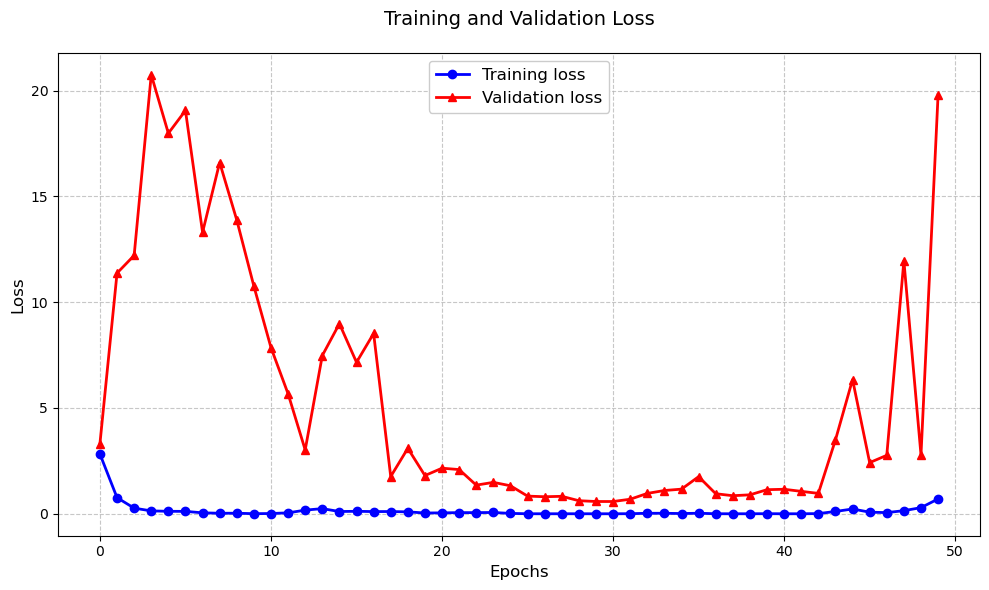

2/2 [==============================] - 0s 52ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        22
           1       0.00      0.00      0.00        20
           2       0.78      0.70      0.74        20

    accuracy                           0.58        62
   macro avg       0.43      0.57      0.47        62
weighted avg       0.43      0.58      0.47        62


📌 Test Set Metrics:
✅ Accuracy:      0.5806
✅ Precision:     0.4283
✅ Recall:        0.5806
✅ F1 Score:      0.4743
✅ Test Loss:     19.0967
✅ ROC AUC:       0.8151

📈 Training Summary:
🟩 Final Train Acc: 0.9520
🟩 Final Train Loss: 0.7012
🟨 Final Val Acc:   0.5469
🟨 Final Val Loss:  19.8072
🔁 Epochs Used:     50


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

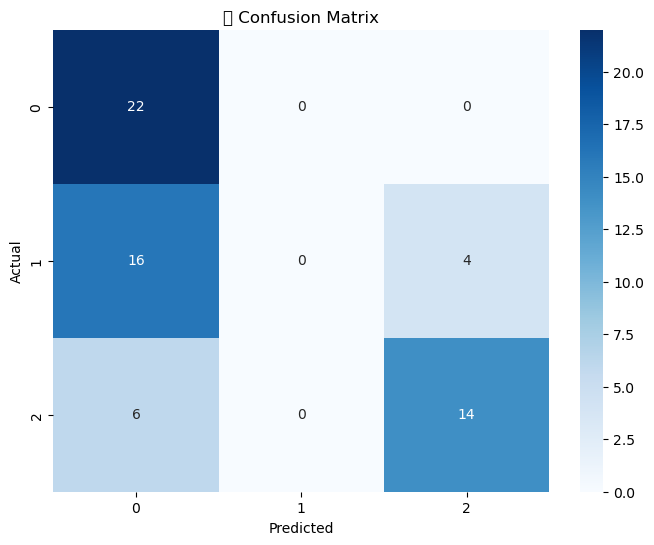

(0.5806451612903226,
 0.42831541218638,
 0.5806451612903226,
 0.4742501414827391,
 19.096725463867188,
 0.8150793650793652)

In [10]:
model_1, callbacks_1 = define_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train)),)
history_1 = model_1.fit(X_train, Y_train, validation_split=0.2, epochs=50, batch_size=42, verbose=1)
loss_curve_plot(history_1)
evaluate_model(model_1, X_test, Y_test,history= history_1) 



### instance 2

Epoch 1/300
31/31 [==============================] - 6s 156ms/step - loss: 2.1330 - accuracy: 0.6939 - val_loss: 3.3230 - val_accuracy: 0.3102
Epoch 2/300
31/31 [==============================] - 5s 152ms/step - loss: 0.6345 - accuracy: 0.8224 - val_loss: 8.1441 - val_accuracy: 0.3673
Epoch 3/300
31/31 [==============================] - 5s 154ms/step - loss: 0.4121 - accuracy: 0.8816 - val_loss: 15.9163 - val_accuracy: 0.3388
Epoch 4/300
31/31 [==============================] - 5s 151ms/step - loss: 0.2466 - accuracy: 0.9184 - val_loss: 18.0240 - val_accuracy: 0.3388
Epoch 5/300
31/31 [==============================] - 5s 153ms/step - loss: 0.1651 - accuracy: 0.9408 - val_loss: 19.7123 - val_accuracy: 0.3388
Epoch 6/300
31/31 [==============================] - 5s 152ms/step - loss: 0.1220 - accuracy: 0.9612 - val_loss: 17.5952 - val_accuracy: 0.3388


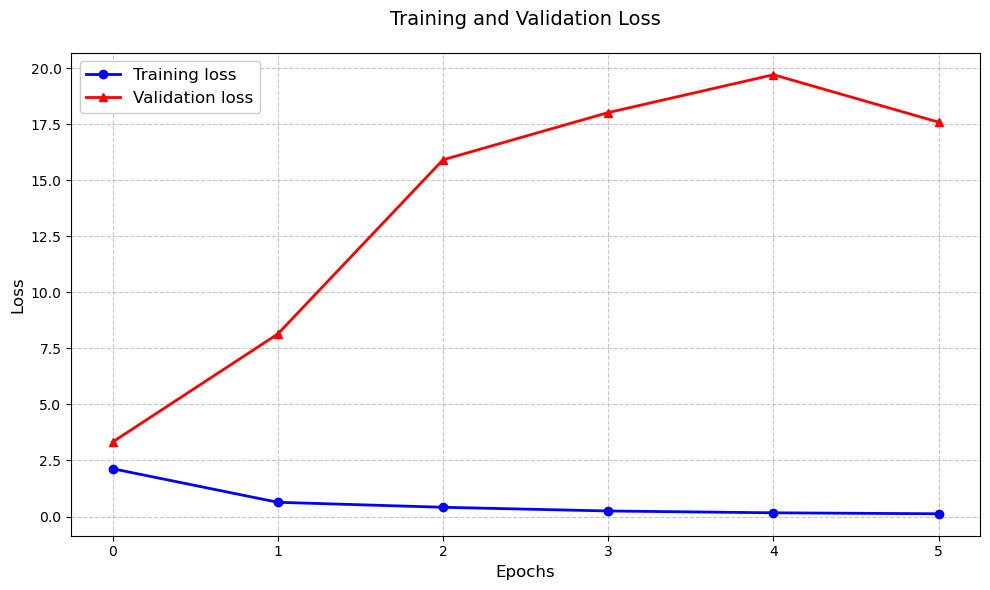

2/2 [==============================] - 0s 46ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.32      0.95      0.48        20
           2       0.00      0.00      0.00        20

    accuracy                           0.31        62
   macro avg       0.11      0.32      0.16        62
weighted avg       0.10      0.31      0.16        62


📌 Test Set Metrics:
✅ Accuracy:      0.3065
✅ Precision:     0.1039
✅ Recall:        0.3065
✅ F1 Score:      0.1552
✅ Test Loss:     3.2733
✅ ROC AUC:       0.6800

📈 Training Summary:
🟩 Final Train Acc: 0.9612
🟩 Final Train Loss: 0.1220
🟨 Final Val Acc:   0.3388
🟨 Final Val Loss:  17.5952
🔁 Epochs Used:     6


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

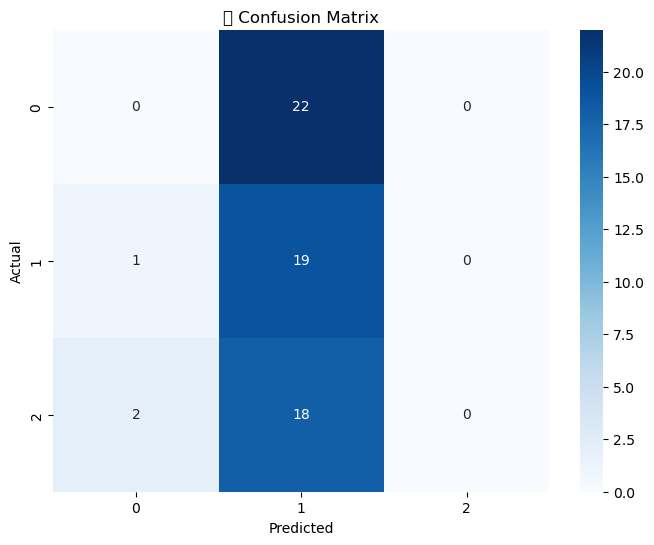

(0.3064516129032258,
 0.10388190267905958,
 0.3064516129032258,
 0.15516537362188648,
 3.273331880569458,
 0.6799603174603174)

In [11]:
model_2, callbacks_2 = define_model(
    optimizer_name='adamax',
    dropout_rate=0.3,
    learning_rate=0.001,
    early_stopping=True,
    input_shape=X_train.shape[1:], 
    num_classes=len(np.unique(Y_train))  
)

history_2 = model_2.fit(
    X_train, Y_train,                  
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=callbacks_2,
    verbose=1
)

loss_curve_plot(history_2)

evaluate_model(model_2, X_test, Y_test, history=history_2)  


### instance 3

Epoch 1/500
31/31 [==============================] - 5s 156ms/step - loss: 2.5483 - accuracy: 0.7061 - val_loss: 1.4820 - val_accuracy: 0.4735
Epoch 2/500
31/31 [==============================] - 5s 152ms/step - loss: 1.1489 - accuracy: 0.8500 - val_loss: 2.2519 - val_accuracy: 0.3265
Epoch 3/500
31/31 [==============================] - 5s 155ms/step - loss: 0.9750 - accuracy: 0.8653 - val_loss: 2.5787 - val_accuracy: 0.3265
Epoch 4/500
31/31 [==============================] - 5s 151ms/step - loss: 0.7941 - accuracy: 0.9194 - val_loss: 4.0387 - val_accuracy: 0.3878
Epoch 5/500
31/31 [==============================] - 5s 150ms/step - loss: 0.7243 - accuracy: 0.9408 - val_loss: 2.5624 - val_accuracy: 0.5633
Epoch 6/500
31/31 [==============================] - 5s 149ms/step - loss: 0.6352 - accuracy: 0.9571 - val_loss: 3.5339 - val_accuracy: 0.5755


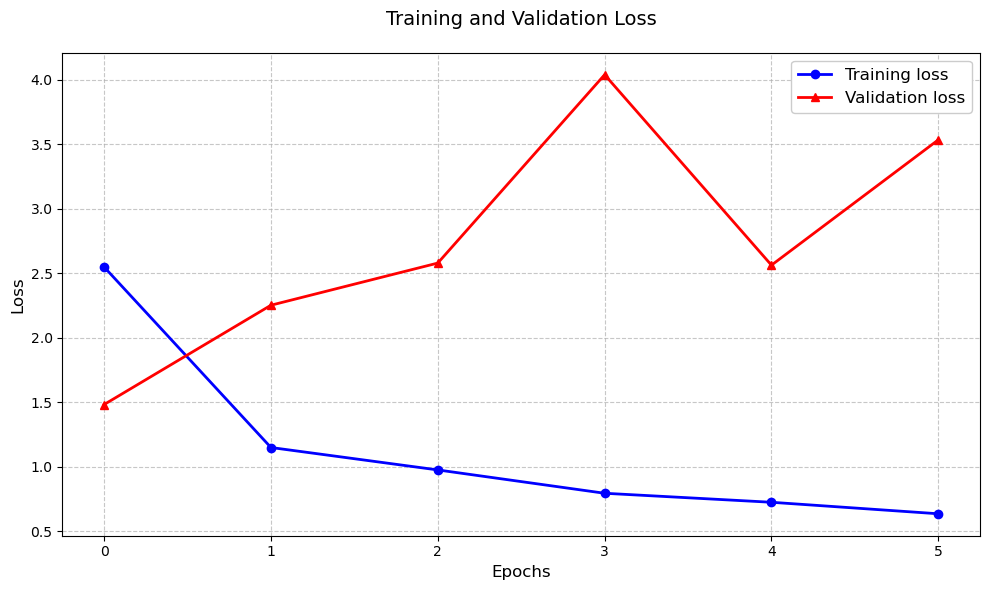

2/2 [==============================] - 0s 46ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.14      0.22        22
           1       0.65      0.85      0.74        20
           2       0.42      0.65      0.51        20

    accuracy                           0.53        62
   macro avg       0.56      0.55      0.49        62
weighted avg       0.56      0.53      0.48        62


📌 Test Set Metrics:
✅ Accuracy:      0.5323
✅ Precision:     0.5591
✅ Recall:        0.5323
✅ F1 Score:      0.4817
✅ Test Loss:     1.3915
✅ ROC AUC:       0.7984

📈 Training Summary:
🟩 Final Train Acc: 0.9571
🟩 Final Train Loss: 0.6352
🟨 Final Val Acc:   0.5755
🟨 Final Val Loss:  3.5339
🔁 Epochs Used:     6


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


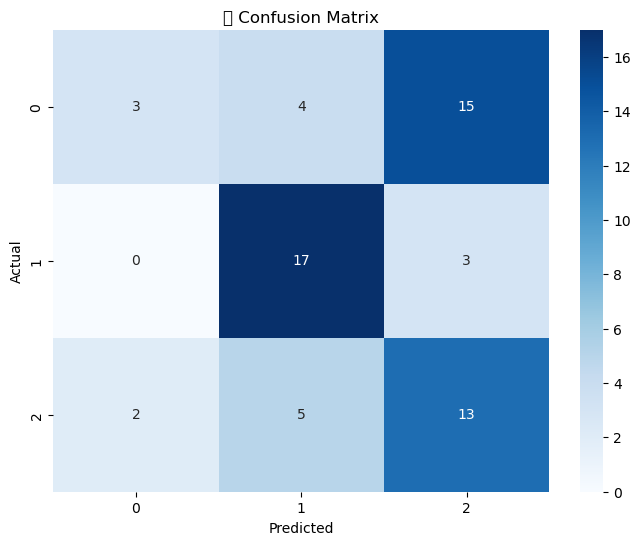

(0.532258064516129,
 0.5590970943728487,
 0.532258064516129,
 0.48173509703086465,
 1.3914762735366821,
 0.7984487734487735)

In [12]:
model_3, callbacks_3 = define_model(
    optimizer_name='RMSprop',
    regularizer_type='l2',
    dropout_rate=0.2,
    learning_rate=0.0005,
    early_stopping=True,
    input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train))
)
history_3 = model_3.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=callbacks_3, verbose=1)
loss_curve_plot(history_3)
evaluate_model(model_3, X_test, Y_test, history=history_3)


### instance 4

Epoch 1/500
24/24 [==============================] - 5s 190ms/step - loss: 32.2262 - accuracy: 0.7082 - val_loss: 32.6165 - val_accuracy: 0.3061
Epoch 2/500
24/24 [==============================] - 4s 177ms/step - loss: 29.8364 - accuracy: 0.9337 - val_loss: 33.7158 - val_accuracy: 0.3061
Epoch 3/500
24/24 [==============================] - 4s 177ms/step - loss: 27.4523 - accuracy: 0.9857 - val_loss: 32.9959 - val_accuracy: 0.3061
Epoch 4/500
24/24 [==============================] - 4s 184ms/step - loss: 24.9887 - accuracy: 1.0000 - val_loss: 31.0694 - val_accuracy: 0.3061
Epoch 5/500
24/24 [==============================] - 4s 180ms/step - loss: 22.5075 - accuracy: 1.0000 - val_loss: 28.6656 - val_accuracy: 0.3061
Epoch 6/500
24/24 [==============================] - 4s 180ms/step - loss: 20.1023 - accuracy: 1.0000 - val_loss: 25.8873 - val_accuracy: 0.3061
Epoch 7/500
24/24 [==============================] - 4s 183ms/step - loss: 17.8363 - accuracy: 1.0000 - val_loss: 23.0894 - val_ac

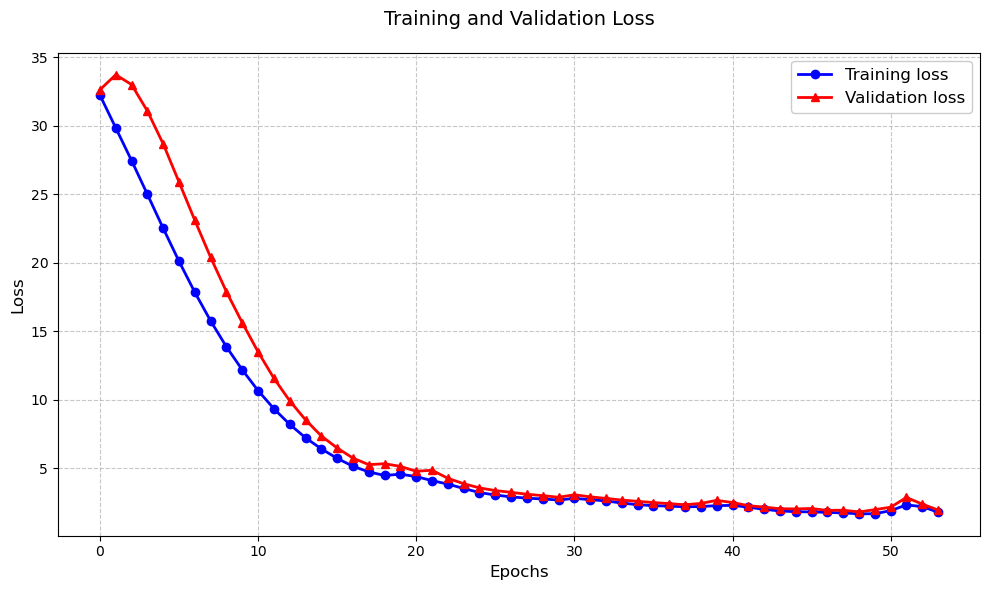

2/2 [==============================] - 0s 69ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.95      0.90      0.92        20
           2       0.95      0.90      0.92        20

    accuracy                           0.92        62
   macro avg       0.92      0.92      0.92        62
weighted avg       0.92      0.92      0.92        62


📌 Test Set Metrics:
✅ Accuracy:      0.9194
✅ Precision:     0.9217
✅ Recall:        0.9194
✅ F1 Score:      0.9195
✅ Test Loss:     1.8659
✅ ROC AUC:       0.9856

📈 Training Summary:
🟩 Final Train Acc: 1.0000
🟩 Final Train Loss: 1.7821
🟨 Final Val Acc:   0.8939
🟨 Final Val Loss:  1.9441
🔁 Epochs Used:     54


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


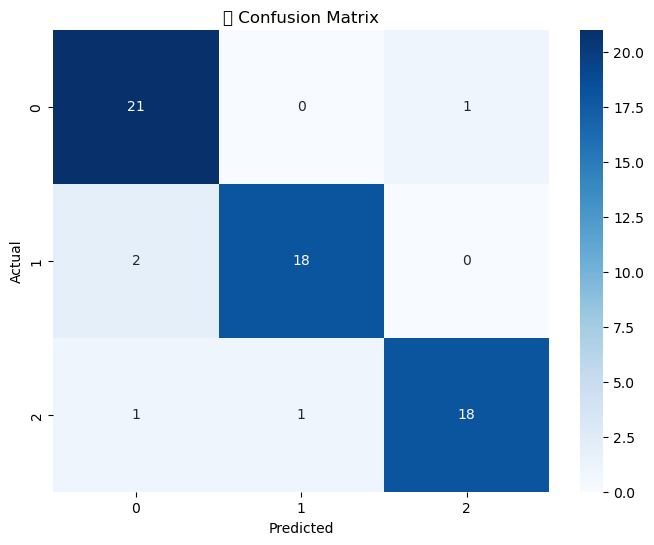

(0.9193548387096774,
 0.9216893039049235,
 0.9193548387096774,
 0.9195166684647752,
 1.86589515209198,
 0.9856240981240981)

In [23]:
model_4, callbacks_4 = define_model(
    optimizer_name='Adam',
    regularizer_type='l1',
    learning_rate=0.0001,
    early_stopping=True,
    input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train))
)
history_4 = model_4.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=42, callbacks=callbacks_4, verbose=1)
loss_curve_plot(history_4)
evaluate_model(model_4, X_test, Y_test,history=history_4)


### instance 5

Epoch 1/500
31/31 [==============================] - 6s 161ms/step - loss: 1.2753 - accuracy: 0.6510 - val_loss: 1.5704 - val_accuracy: 0.3388
Epoch 2/500
31/31 [==============================] - 5s 156ms/step - loss: 0.7283 - accuracy: 0.9133 - val_loss: 1.6189 - val_accuracy: 0.3388
Epoch 3/500
31/31 [==============================] - 5s 157ms/step - loss: 0.5877 - accuracy: 0.9786 - val_loss: 1.6475 - val_accuracy: 0.3388
Epoch 4/500
31/31 [==============================] - 5s 155ms/step - loss: 0.5274 - accuracy: 0.9980 - val_loss: 1.6963 - val_accuracy: 0.3429
Epoch 5/500
31/31 [==============================] - 5s 155ms/step - loss: 0.5074 - accuracy: 1.0000 - val_loss: 1.7104 - val_accuracy: 0.5306
Epoch 6/500
31/31 [==============================] - 5s 151ms/step - loss: 0.4976 - accuracy: 1.0000 - val_loss: 1.6880 - val_accuracy: 0.5102


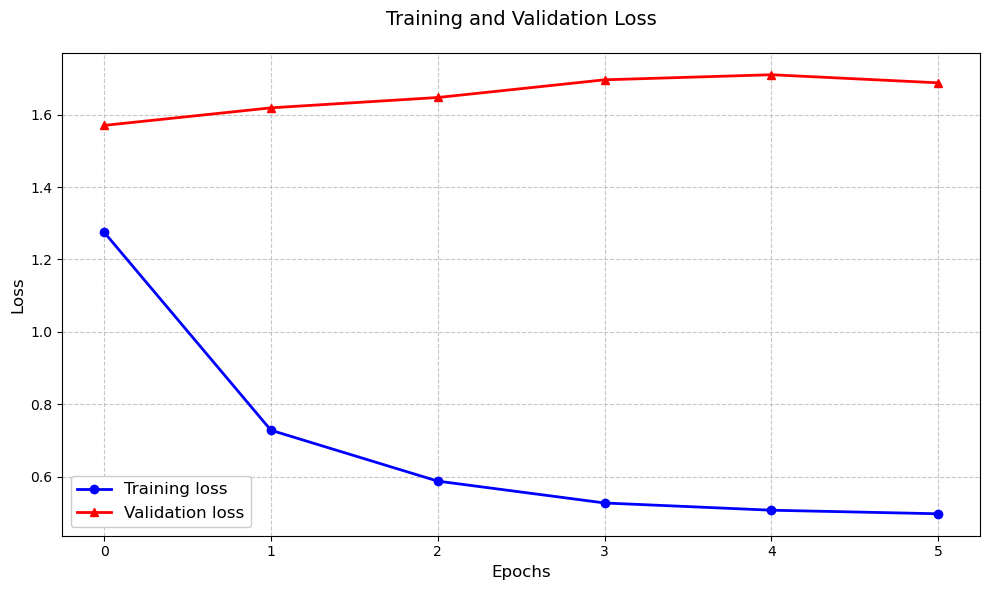

2/2 [==============================] - 0s 48ms/step

📊 Classification Report:

              precision    recall  f1-score   support

           0       0.35      1.00      0.52        22
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20

    accuracy                           0.35        62
   macro avg       0.12      0.33      0.17        62
weighted avg       0.13      0.35      0.19        62


📌 Test Set Metrics:
✅ Accuracy:      0.3548
✅ Precision:     0.1259
✅ Recall:        0.3548
✅ F1 Score:      0.1859
✅ Test Loss:     1.5574
✅ ROC AUC:       0.7638

📈 Training Summary:
🟩 Final Train Acc: 1.0000
🟩 Final Train Loss: 0.4976
🟨 Final Val Acc:   0.5102
🟨 Final Val Loss:  1.6880
🔁 Epochs Used:     6


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

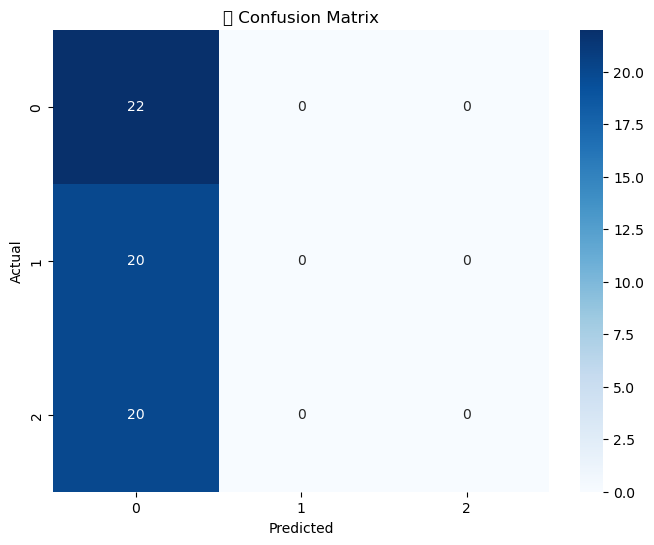

(0.3548387096774194,
 0.1259105098855359,
 0.3548387096774194,
 0.1858678955453149,
 1.5574231147766113,
 0.7637987012987013)

In [14]:
model_5, callbacks_5 = define_model(
    optimizer_name='SDG',
    regularizer_type='l2',
    learning_rate=0.00002,
    early_stopping=True,
    input_shape=X_train.shape[1:], num_classes=len(np.unique(Y_train))
)
history_5 = model_5.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=callbacks_5, verbose=1)
loss_curve_plot(history_5)
evaluate_model(model_5, X_test, Y_test, history=history_5)


# Save the best model compare all model

In [24]:
import os
import joblib
import pandas as pd


# Define your model-history-optimizer sets
models = [model_1, model_2, model_3, model_4, model_5]
histories = [history_1, history_2, history_3, history_4, history_5]
optimizers = ['None', 'adamax', 'rmsprop', 'adam', 'sgd']  # fixed 'SDG' to 'sgd'

results = {}

for i, (model, history, opt_name) in enumerate(zip(models, histories, optimizers), start=1):
    name = f"{opt_name}_model_{i}"
    print(f"\n🔍 Evaluating {name}")

    acc, prec, rec, f1, loss, roc_auc = evaluate_model(model, X_test, Y_test, history=history, show=False)

    # Print metrics for each model
    print(f"📌 Optimizer:  {opt_name}")
    print(f"✅ Accuracy:   {acc:.4f}")
    print(f"✅ Precision:  {prec:.4f}")
    print(f"✅ Recall:     {rec:.4f}")
    print(f"✅ F1 Score:   {f1:.4f}")
    print(f"✅ Loss:       {loss:.4f}")
    print(f"✅ ROC AUC:    {roc_auc:.4f}" if roc_auc is not None else "❌ ROC AUC not available")

    # Store metrics
    results[name] = {
        "model": model,
        "optimizer": opt_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "loss": loss,
        "roc_auc": roc_auc
    }

    # Save model file
    model_path = f"saved_models/{name}.pkl"
    joblib.dump(model, model_path)
    print(f"💾 Saved {name} to {model_path}")

# Create a DataFrame for the summary (excluding the model objects)
results_df = pd.DataFrame({
    name: {k: v for k, v in metrics.items() if k != 'model'}
    for name, metrics in results.items()
}).T

print("\n📊 Summary of All Models:\n")
print(results_df[['optimizer', 'accuracy', 'precision', 'recall', 'f1', 'loss', 'roc_auc']]
      .sort_values(by="f1", ascending=False)
      .to_string(index=True))

# Choose best model based on F1 > ROC AUC > Accuracy
def model_score(metrics):
    return (
        metrics["f1"],
        metrics["roc_auc"] if metrics["roc_auc"] is not None else 0,
        metrics["accuracy"]
    )

best_model_name = max(results, key=lambda k: model_score(results[k]))
best_model_metrics = results[best_model_name]
best_model = best_model_metrics["model"]

print(f"\n🏆 Best Model: {best_model_name}")
print("📌 Metrics:")
print(f"✅ Accuracy:   {best_model_metrics['accuracy']:.4f}")
print(f"✅ Precision:  {best_model_metrics['precision']:.4f}")
print(f"✅ Recall:     {best_model_metrics['recall']:.4f}")
print(f"✅ F1 Score:   {best_model_metrics['f1']:.4f}")
print(f"✅ Loss:       {best_model_metrics['loss']:.4f}")
if best_model_metrics["roc_auc"] is not None:
    print(f"✅ ROC AUC:    {best_model_metrics['roc_auc']:.4f}")

# Save best model again with optimizer in the filename
best_model_save_name = f"saved_models/best_model_{best_model_metrics['optimizer']}.pkl"
joblib.dump(best_model, best_model_save_name)
print(f"\n✅ Best model saved as: {best_model_save_name}")



🔍 Evaluating None_model_1
2/2 [==============================] - 0s 65ms/step


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📌 Optimizer:  None
✅ Accuracy:   0.5806
✅ Precision:  0.4283
✅ Recall:     0.5806
✅ F1 Score:   0.4743
✅ Loss:       19.0967
✅ ROC AUC:    0.8151
💾 Saved None_model_1 to saved_models/None_model_1.pkl

🔍 Evaluating adamax_model_2
2/2 [==============================] - 0s 64ms/step


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📌 Optimizer:  adamax
✅ Accuracy:   0.3065
✅ Precision:  0.1039
✅ Recall:     0.3065
✅ F1 Score:   0.1552
✅ Loss:       3.2733
✅ ROC AUC:    0.6800
💾 Saved adamax_model_2 to saved_models/adamax_model_2.pkl

🔍 Evaluating rmsprop_model_3
2/2 [==============================] - 0s 68ms/step
📌 Optimizer:  rmsprop
✅ Accuracy:   0.5323
✅ Precision:  0.5591
✅ Recall:     0.5323
✅ F1 Score:   0.4817
✅ Loss:       1.3915
✅ ROC AUC:    0.7984
💾 Saved rmsprop_model_3 to saved_models/rmsprop_model_3.pkl

🔍 Evaluating adam_model_4
2/2 [==============================] - 0s 68ms/step
📌 Optimizer:  adam
✅ Accuracy:   0.9194
✅ Precision:  0.9217
✅ Recall:     0.9194
✅ F1 Score:   0.9195
✅ Loss:       1.8659
✅ ROC AUC:    0.9856
💾 Saved adam_model_4 to saved_models/adam_model_4.pkl

🔍 Evaluating sgd_model_5
2/2 [==============================] - 0s 71ms/step


/home/lscblack/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📌 Optimizer:  sgd
✅ Accuracy:   0.3548
✅ Precision:  0.1259
✅ Recall:     0.3548
✅ F1 Score:   0.1859
✅ Loss:       1.5574
✅ ROC AUC:    0.7638
💾 Saved sgd_model_5 to saved_models/sgd_model_5.pkl

📊 Summary of All Models:

                optimizer  accuracy precision    recall        f1       loss   roc_auc
adam_model_4         adam  0.919355  0.921689  0.919355  0.919517   1.865895  0.985624
rmsprop_model_3   rmsprop  0.532258  0.559097  0.532258  0.481735   1.391476  0.798449
None_model_1         None  0.580645  0.428315  0.580645   0.47425  19.096725  0.815079
sgd_model_5           sgd  0.354839  0.125911  0.354839  0.185868   1.557423  0.763799
adamax_model_2     adamax  0.306452  0.103882  0.306452  0.155165   3.273332   0.67996

🏆 Best Model: adam_model_4
📌 Metrics:
✅ Accuracy:   0.9194
✅ Precision:  0.9217
✅ Recall:     0.9194
✅ F1 Score:   0.9195
✅ Loss:       1.8659
✅ ROC AUC:    0.9856

✅ Best model saved as: saved_models/best_model_adam.pkl


## Model Summarries

In [16]:
## Model Summarries
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                        

In [17]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                      

In [18]:
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)       

In [19]:
model_4.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 32)     

In [20]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_13 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                      

# Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [21]:
from joblib import load
def make_predictions(model_path, X):
    # Load the trained model from file
    model = load(model_path)
    
    # Check if classifier supports probability prediction
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)
        predictions = np.argmax(y_prob, axis=1)
    else:
        predictions = model.predict(X)
    
    return predictions


In [37]:
import numpy as np

# Index of the sample you want to predict
idx = 20

# Prepare input with batch dimension
single_input = np.expand_dims(X_test[idx], axis=0)

# Make prediction (assuming model outputs probabilities)
preds = make_predictions("saved_models/best_model_adam.pkl", single_input)

# Actual label
actual_label = Y_test[idx]

# predicted probabilities for the first sample
pred_probs = preds[0]  

# Get the predicted class as the index with the max probability
pred_label = np.argmax(pred_probs)

print(f"Actual label:    {actual_label}")
print(f"Predicted label: {pred_label}")
print(f"Probabilities:   {pred_probs}")


1/1 [==============================] - 0s 74ms/step
Actual label:    2
Predicted label: 2
Probabilities:   [0.1067984  0.02100544 0.87219614]
1/1 [==============================] - 0s 74ms/step
Actual label:    2
Predicted label: 2
Probabilities:   [0.1067984  0.02100544 0.87219614]


Congratulations!!
